In [1]:
save_dir_name = 'simple___2021_09_18___11_17_26___first_try'

In [2]:
import sys
import os
import numpy as np
import pickle
import pandas as pd

# Load all data

In [3]:
# files paths
home_dir_path = os.path.expanduser("~")
work_dir_path = os.path.join(home_dir_path, 'workdir3')
code_dir_path = os.path.join(work_dir_path , 'code')
saves_dir_path = os.path.join(work_dir_path , 'model_saves')
data_dir_path = os.path.join(work_dir_path , 'data')
data_ver_dir_path = os.path.join(data_dir_path,'HighSNR_12K_V1')
save_dir_path = os.path.join(saves_dir_path, save_dir_name)

# adding code folder to path
sys.path.insert(1, code_dir_path)

In [4]:
print('Loading saved data')
I_slice = np.load(os.path.join(save_dir_path, 'I_slice.npy'))
I_train = np.load(os.path.join(save_dir_path, 'I_train.npy'))
X_train_real = np.load(os.path.join(save_dir_path, 'X.npy'))
X_leaves_train_real = np.load(os.path.join(save_dir_path, 'X_leaves.npy'))
Y_hat_train_real = np.load(os.path.join(save_dir_path, 'Y_hat.npy'))
weird_scores = np.load(os.path.join(save_dir_path, 'weirdness_scores.npy'))
sne = np.load(os.path.join(save_dir_path, 'tsne.npy'))

print('Loading wavelength grid and dataframe')
wl_grid = np.load(os.path.join(save_dir_path, 'wl_grid.npy'))
with open(os.path.join(data_ver_dir_path, 'gs.pkl'), 'rb') as handle:
    gs = pickle.load(handle)
I_real_train = I_train[I_train<len(I_slice)]
snr = gs.snMedian.iloc[I_slice[I_real_train]]

print('Loading random forest')
from CustomRandomForest import CustomRandomForest
rf = CustomRandomForest.load(os.path.join(save_dir_path, 'crf.pkl'))

print('Loading decision paths')
with open(os.path.join(save_dir_path, 'decision_paths.pkl'),'rb') as f:
    decision_paths = pickle.load(f)

print('done.')

Loading saved data
Loading wavelength grid and dataframe
Loading random forest
Loading decision paths
done.


In [5]:
wl_grid = np.load(os.path.join(save_dir_path, 'wl_grid.npy'))
len(wl_grid)

7800

# Plot

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
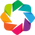

In [6]:
import holoviews as hv
from holoviews import opts
from holoviews.streams import Selection1D
from bokeh.models import HoverTool
from scipy import stats
import panel as pn
hv.extension('bokeh')

In [7]:
# creading the dataframe
df = pd.DataFrame(sne, columns=['feature_1', 'feature_2'])
df['score'] = weird_scores
df['snr'] = snr
df['index'] = np.arange(len(df))

In [8]:
import collections
import scipy
def create_wavelengths_importance(index, filt=True, norm=True):
    """
    returns the wavelength importances  for the cluster of the indices in "index"
    """
    X_leaves = X_leaves_train_real[index,:]
    Y_hat = Y_hat_train_real[index,:]
    heat_map = np.zeros(shape=wl_grid.shape) # initializing the array
    good_preds = Y_hat == 1 # weather it is a good prediction (real) or not
    keys = []
    for i in range(len(index)):
        for j in range(i+1, len(index)):
            # for each couple of samples (i,j)
            valid = np.where(np.logical_and(good_preds[i,:], good_preds[j,:]))[0] # indices of trees that classified both i and j as real
            if len(valid)>0:
                i_good_trees = np.where(X_leaves[i,valid] == X_leaves[j,valid])[0] # out of the valid trees - the indices of trees which had i and j in the same leaf
                keys.extend([(index[i],k) for k in valid[i_good_trees]])
                
    counter = collections.Counter(keys)
    for key,value in counter.items():
        heat_map[decision_paths[key]] += value
    
    if filt:
        heat_map = scipy.ndimage.gaussian_filter1d(heat_map, 10)
    
    if norm:
        heat_map /= np.max(heat_map)
    
    return heat_map

In [9]:
import collections
import scipy
def create_outlier_wavelengths_importance(i, filt=True, norm=True):
    """
    returns the wavelength importances of outlier in index "i"
    """
    heat_map = np.zeros(shape=wl_grid.shape) # initializing the array
    good_preds = Y_hat_train_real == 1 # weather it is a good prediction (real) or not
    keys = []
    for j in range(Y_hat_train_real.shape[0]):
        if i != j:
            # for each couple of samples (i,j)
            valid = np.where(np.logical_and(good_preds[i,:], good_preds[j,:]))[0] # indices of trees that classified both i and j as real
            if len(valid)>0:
                i_bad_trees = np.where(X_leaves_train_real[i,valid] != X_leaves_train_real[j,valid])[0] # out of the valid trees - the indices of trees which had i and j not in the same leaf
                keys.extend([(j,k) for k in valid[i_bad_trees]])
                
    counter = collections.Counter(keys)
    for key,value in counter.items():
        heat_map[decision_paths[key]] += value
    
    if filt:
        heat_map = scipy.ndimage.gaussian_filter1d(heat_map, 10)
    
    if norm:
        heat_map /= np.max(heat_map)
    
    return heat_map

In [10]:
def points_dmap_callable(color_src):
    """
    The callable function for the points DynamicMap.
    """
    points = hv.Points(df).opts(color=color_src, cmap='jet')
    points.opts(tools=['tap','box_select','lasso_select'])
    points.opts(selection_alpha=0.4, nonselection_alpha=0.1)
    return points

In [11]:
def create_spectra_layout(data, label):
    flux = hv.Curve((data[0],data[1]), kdims=['w'],vdims=['flux'], label='flux').opts(color='black').opts(norm=dict(framewise=True)).opts(tools=['hover'])
    imp = hv.Points((data[0],data[1],data[3]), kdims=['w','flux'], vdims=['imp'], label='importance').opts(color='imp', cmap='jet', muted_alpha=0)
    return (flux * imp).relabel(label).opts(width=800, height=300, show_grid=True).opts(legend_position='top_left')

def spectra_dmap_callable(index):
    """
    The callable function for the spectra DynamicMap.
    """
    if len(index)==0:
        # No Selection
        data = (wl_grid, np.zeros(shape=wl_grid.shape), np.zeros(shape=wl_grid.shape), np.zeros(shape=wl_grid.shape), np.zeros(shape=wl_grid.shape))
        label = 'No Selection'
    elif len(index)==1:
        # a single point - plotting the outlier feature importance
        x = X_train_real[index[0]]
        x_valid = ~np.isnan(x)
        importance = create_outlier_wavelengths_importance(index[0])
        data = (wl_grid[x_valid], x[x_valid], None, importance[x_valid])
        label = 'index=%s, snr=%f, score=%f' % (index[0], snr[index[0]], weird_scores[index[0]])
    else:
        # Multiple points - plotting the cluster feature importance
        np.save(os.path.join(save_dir_path, 'cluster.npy'), index) # saving indices for later debug
        x = np.nanmean(X_train_real[index], axis=0)
        x_valid = ~np.isnan(x)
        importance = create_wavelengths_importance(index)
        data = (wl_grid[x_valid], x[x_valid], None, importance[x_valid])
        label = '%d points selected - plotting the average' % len(index)

    return create_spectra_layout(data, label)

In [12]:
def examples_dmap_callable(index):
    """
    The callable function for the examples DynamicMap.
    """
    spectra_dict = {i:hv.Curve((wl_grid,X_train_real[ind])).relabel('index=%s, snr=%f, score=%f' % (ind, snr[ind], weird_scores[ind])).opts(width=800, height=300, show_grid=True) for i,ind in enumerate(index)}

    return hv.HoloMap(spectra_dict, kdims='index')

In [13]:
# Creating the T-SNR Points DynamicMap (Dynamic because of 2 color sources - score and snr)
points_dmap = hv.DynamicMap(points_dmap_callable, kdims='ColorSource').redim.values(ColorSource=['score','snr'])
points_dmap.opts(framewise=True, width=800, height=500, colorbar=True)
selection = Selection1D(source=points_dmap) # creating a selection from the points

# Creating the spectra DynamicMap - to load the spectra according to the selection from the selection of the T-SNE points.
spectra_dmap = hv.DynamicMap(spectra_dmap_callable, kdims=[], streams=[selection])
spectra_dmap.opts(norm=dict(framewise=True))

# Building the layout full layout
layout = (points_dmap + spectra_dmap).opts(merge_tools=False)
layout.cols(1)

pn.pane.HoloViews(layout, widget_location="top")

HoloViews(Layout, widget_location='top')

# Manual plot

0.11986199886138739


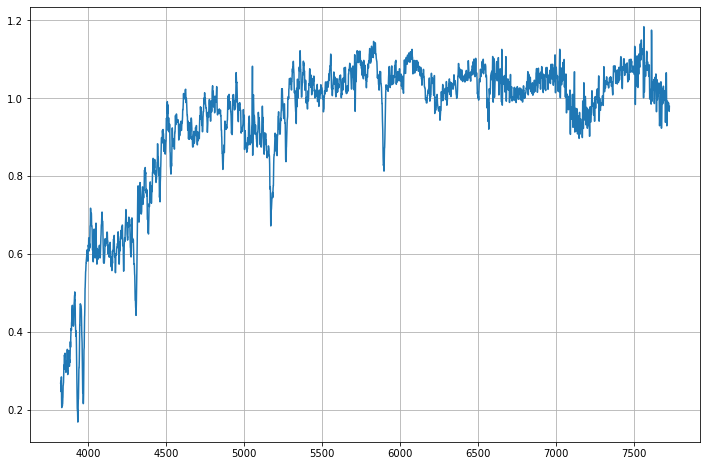

In [14]:
from matplotlib import pyplot as plt
I_weird = np.argsort(weird_scores)
i = 0
print(weird_scores[I_weird[i]])
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(wl_grid, X_train_real[I_weird[i],:])
ax.grid()

# Other stuff

In [ ]:
gs = data['gs'].iloc[I_train[I_train<len(data['gs'])]]

In [ ]:
g = gs.iloc[6899]
from NAURF import getUrl
from astropy.io import fits
url = getUrl(g)
# Get data from .fits file (download from url)
hdulist = fits.open(url, memmap=False, cache=False)
data = hdulist[1].data
specobjid = int(hdulist[2].data['specobjid'].item())
hdulist.close()

# Make sure the file matches the galaxy desired
assert str(specobjid) == g['specobjid'], 'Files do not match galaxies dataframe'

# Get flux values and wavelengths
y = data['flux']
x = np.array(10 ** data['loglam'], dtype=float)
dy = data['ivar']
hv.Curve((x,y)).opts(width=800, height=300, show_grid=True)

# Auxilary Plots

In [ ]:
holomap = examples_dmap_callable(np.load(os.path.join(save_dir_path, 'cluster.npy'))).opts(width=800, height=300, show_grid=True)
holomap_panel = pn.panel(holomap)
plot = holomap_panel[0]
widgets = holomap_panel[1]
new_layout_panel = pn.Column(plot, widgets)
new_layout_panel.servable()

# Debugging

In [ ]:
# plotting the mean spectra of the dataset
hv.Curve((wl_grid, np.nanmean(X_train_real, axis=0))).opts(width=800, height=300, show_grid=True)

In [ ]:
# plotting the importances of the saved cluster
index = np.load(os.path.join(save_dir_path, 'cluster.npy')) # loading the saved indices
importance = create_wavelengths_importance(index, filt=False, norm=False)
hv.Curve((wl_grid, importance)).opts(width=800, height=300, show_grid=True).opts(tools=['hover'])

In [ ]:
# plotting the importances of the saved cluster
index = np.load(os.path.join(save_dir_path, 'cluster.npy')) # loading the saved indices
importance = create_wavelengths_importance(index, filt=False, norm=False)
hv.Curve((wl_grid, importance)).opts(width=800, height=300, show_grid=True).opts(tools=['hover'])

In [ ]:
# plotting the importances of the saved cluster
index = np.load(os.path.join(save_dir_path, 'cluster.npy')) # loading the saved indices
importance = create_wavelengths_importance(index, filt=False, norm=False)
hv.Curve((wl_grid, importance)).opts(width=800, height=300, show_grid=True).opts(tools=['hover'])

In [ ]:
# plotting the marginal distribution 
wl = 5658
wl_i = np.where(wl_grid==wl)[0][0]
x_cluster = X_train_real[index,wl_i]
x_real = X_train[y_train==1,wl_i]
x_synth = X_train[y_train==2,wl_i]

grid = np.linspace(0,3,20)
cluster_freq, cluster_edges = np.histogram(x_cluster, grid, density=True)
real_freq, real_edges = np.histogram(x_real[~np.isnan(x_real)], grid, density=True)
synth_freq, synth_edges = np.histogram(x_synth[~np.isnan(x_synth)], grid, density=True)
cluster_centers = (cluster_edges[:-1]+cluster_edges[1:])/2
real_centers = (real_edges[:-1]+real_edges[1:])/2
synth_centers = (synth_edges[:-1]+synth_edges[1:])/2
comp = hv.Curve((cluster_centers, cluster_freq),label='cluster')*hv.Curve((real_centers, real_freq), label='real')*hv.Curve((synth_centers, synth_freq), label='synth')
comp.opts(width=800, height=300, show_grid=True)

# Other code...

In [ ]:
# Creating the decision paths dictionary
from progressbar import progressbar
decision_paths = dict()
for k in progressbar(range(len(rf.estimators_))):
    i_real = np.where(Y_hat_train_real[:,k]==1)[0] # indices of all samples which the k-th tree classified as "real"
    i_sample,i_node = rf.estimators_[k].tree_.decision_path(X_train_real[i_real,rf.tree_i_start[k]:rf.tree_i_end[k]].astype(np.float32)).nonzero()
    i_feature = rf.tree_i_start[k]+rf.estimators_[k].tree_.feature[i_node]
    for i in range(len(i_real)):
        temp_feature = i_feature[i_sample==i]
        decision_paths[(i_real[i],k)] = temp_feature[:-1] # the last node is a leaf (not a decision node)
        
# saving it
import pickle
with open(decision_paths_path,'wb') as f:
    pickle.dump(decision_paths, f)
    
# decision_paths_2 = [[decision_paths[(i,k)] if (i,k) in decision_paths else None for k in range(Y_hat_train_real.shape[1])] for i in range(Y_hat_train_real.shape[0])]